In [754]:
import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt  # 导入Matplotlib库

以下为计算成对距离的函数，它的原理是：对于每个点，计算它与其他点的距离，然后取最小的距离作为它的成对距离。这样，每个点都有一个成对距离，然后取所有点的成对距离的平均值作为最终的成对距离。

In [755]:
# 计算成对距离的函数
def pairwise_distances(X):
    dist_matrix = np.sqrt(np.sum((X[:, None] - X) ** 2, axis=2))
    return dist_matrix

In [756]:
# 计算最近邻的索引
def nearest_neighbors(X, n_neighbors):
    dist_matrix = pairwise_distances(X)
    return dist_matrix.argsort(axis=1)[:, 1:n_neighbors+1]

In [757]:
def construct_weight_matrix(X, n_neighbors, method, epsilon, t):
    n = len(X)  # 计算数据集样本点的数量
    Weight_matrix = np.zeros((n, n))  # 创建一个全零的邻接矩阵，尺寸为 (n, n)
    if method == 'epsilon':  # 如果方法为epsilon邻域
        for i in range(n):  # 对于数据集中的每个样本点 i
            for j in range(n):  # 对于数据集中的每个样本点 j
                if np.linalg.norm(X[i] - X[j]) < epsilon:  # 如果样本点 i 和 j 之间的距离小于 epsilon
                    Weight_matrix[i, j] = np.exp(- np.linalg.norm(X[i] - X[j]) ** 2 / t)  # 使用热核方法计算权重
                    Weight_matrix[j, i] = np.exp(- np.linalg.norm(X[j] - X[i]) ** 2 / t)  #邻接矩阵为对称矩阵

    elif method == 'knn':  # 如果方法为k最近邻
        dist_matrix = pairwise_distances(X)  # 计算数据集中样本点之间的距离
        np.savetxt('dist_matrix.csv', dist_matrix, delimiter=',')
        knn_matrix = nearest_neighbors(X, n_neighbors)  # 计算每个样本点的 n_neighbors 个最近邻索引
        np.savetxt('knn_matrix.csv', knn_matrix, delimiter=',')
        for i in range(len(X)):  # 对于数据集中的每个样本点 i
            for j in knn_matrix[i]:  # 对于样本点 i 的 n_neighbors 个最近邻点 j
                Weight_matrix[i][int(j)] = np.exp(- dist_matrix[i][int(j)] ** 2 / t)  # 使用热核方法计算权重
                Weight_matrix[int(j)][i] = np.exp(- dist_matrix[int(j)][i] ** 2 / t)  #邻接矩阵为对称矩阵

    return Weight_matrix  # 返回构建完成的邻接矩阵

In [758]:
# 进行特征映射
def eigen_mapping(L, n_components):
    # 计算广义特征值问题的特征向量和特征值
    eigenvalues, eigenvectors = eigh(L)
    np.savetxt('eigenvalues.csv', eigenvalues, delimiter=',')
    np.savetxt('eigenvectors.csv', eigenvectors, delimiter=',')
    # 将特征向量按照特征值从小到大排序
    sorted_indices = np.argsort(eigenvalues)
    # 选择最小的 n_components 个特征向量
    selected_indices = sorted_indices[:n_components + 1]
    # 丢弃最小的特征向量
    selected_indices = selected_indices[1:]
    # 返回特征向量
    selected_eigenvectors = eigenvectors[:, selected_indices]
    np.savetxt('selected_eigenvectors.csv', selected_eigenvectors, delimiter=',')
    return selected_eigenvectors

In [759]:
# LPP算法
def LPP(X, n_neighbors, n_components, method, epsilon, t ):
    # Step 1: 构建权重矩阵
    Weight_matrix = construct_weight_matrix(X, n_neighbors, method, epsilon, t )

    np.savetxt('Weight_matrix.csv', Weight_matrix, delimiter=',')

    # Step 2: 计算度矩阵和拉普拉斯矩阵
    Degree_matrix = np.diag(np.sum(Weight_matrix, axis=1))

    np.savetxt('Degree_matrix.csv', Degree_matrix, delimiter=',')
    
    Laplacian_matrix = Degree_matrix - Weight_matrix

    np.savetxt('Laplacian_matrix.csv', Laplacian_matrix, delimiter=',')

    # Step 4: 进行特征映射
    selected_eigenvectors = eigen_mapping(Laplacian_matrix, n_components)

    np.savetxt('selected_eigenvectors.csv', selected_eigenvectors, delimiter=',')
    
    return selected_eigenvectors

In [760]:
# 示例数据
X = np.load('D:/OneDrive - email.szu.edu.cn/Manifold Learning/swiss roll-1000.npy')

np.savetxt('X.csv', X, delimiter=',')

# 将 X 格式化为 (n_samples, n_features)
X_trans = np.transpose(X)

np.savetxt('X_trans.csv', X_trans, delimiter=',')

# 设置降维参数
n_neighbors = 150
n_components = 2
method = 'knn' # 方法选择knn或者epsilon
epsilon=1
t=60 # 设置热核参数

# 执行LPP算法
lpp_embeddings = LPP(X_trans, n_neighbors=n_neighbors, n_components=n_components, method=method, epsilon=epsilon, t=t)


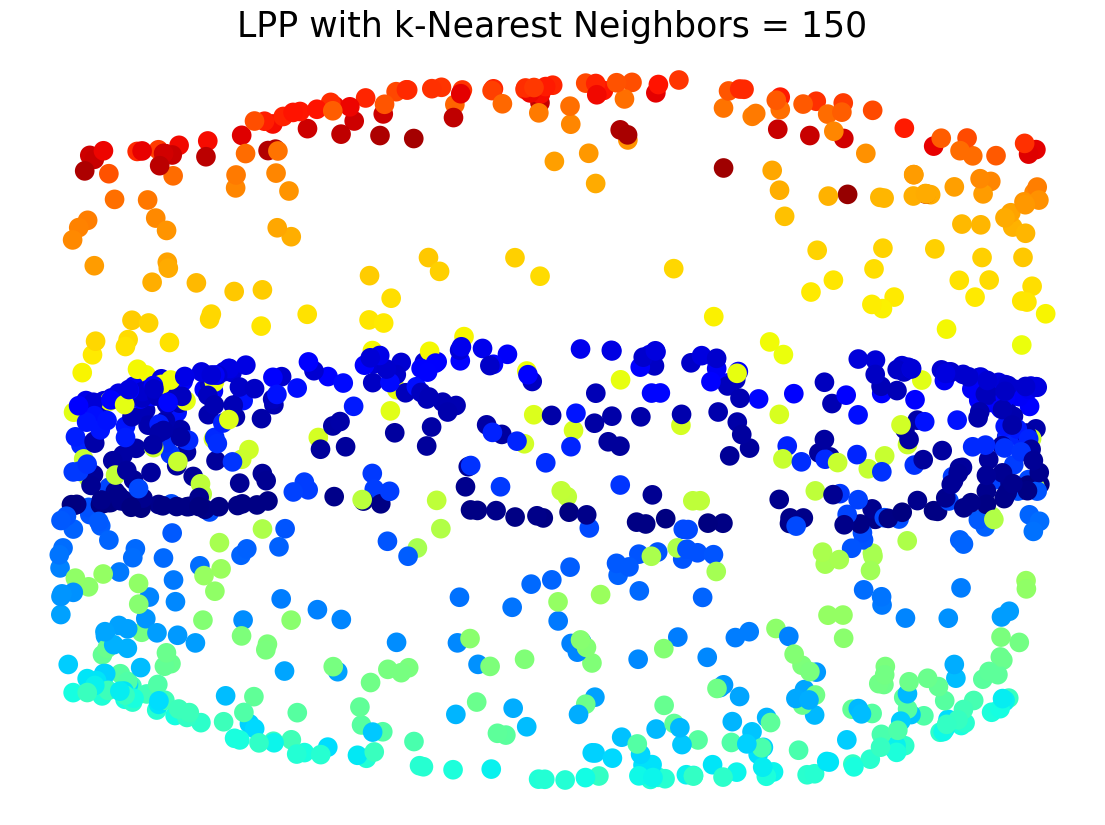

In [761]:
# 绘制投影图
plt.figure(figsize=(14,10))
plt.scatter(lpp_embeddings[:, 0], lpp_embeddings[:, 1], c=plt.cm.jet((X_trans[:,0]**2+X_trans[:,2]**2)/100), s=200, lw=0, alpha=1)
plt.title('LPP with k-Nearest Neighbors = ' + str(n_neighbors), size=25)
plt.axis("off")
plt.show()

In [762]:
import pandas as pd
csvs = ['X.csv', 'X_trans.csv', 'dist_matrix.csv', 'knn_matrix.csv', 'Weight_matrix.csv', 'Degree_matrix.csv', 'Laplacian_matrix.csv','eigenvalues.csv', 'eigenvectors.csv', 'selected_eigenvectors.csv']
for csv in csvs:
    df = pd.read_csv(csv, header=None)
    dimension = df.shape
    print(f"Dimension of {csv}: {dimension}")

Dimension of X.csv: (3, 1000)
Dimension of X_trans.csv: (1000, 3)
Dimension of dist_matrix.csv: (1000, 1000)
Dimension of knn_matrix.csv: (1000, 150)
Dimension of Weight_matrix.csv: (1000, 1000)
Dimension of Degree_matrix.csv: (1000, 1000)
Dimension of Laplacian_matrix.csv: (1000, 1000)
Dimension of eigenvalues.csv: (1000, 1)
Dimension of eigenvectors.csv: (1000, 1000)
Dimension of selected_eigenvectors.csv: (1000, 2)
